## Unbanked Paper

## EDA + Model Train Testing

### Install / import libraries

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### Utility helpers

In [ ]:
TODAY = pd.Timestamp("2025-01-01")        # keep fixed for reproducibility

def prep_dates(df, col):
    return (TODAY - pd.to_datetime(df[col], errors="coerce")).dt.days / 365.25

def parse_subscription_list(s):
    if pd.isna(s):
        return 0
    try:
        return len(eval(s))
    except Exception:
        return 0


def cv_evaluate(clf, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    metrics = {"AUC":[], "F1":[], "Precision":[], "Recall":[], "KS":[]}

    for tr, te in skf.split(X, y):
        clf.fit(X.iloc[tr], y.iloc[tr])
        proba = clf.predict_proba(X.iloc[te])[:, 1]
        pred  = (proba >= 0.5).astype(int)

        metrics["AUC"].append(roc_auc_score(y.iloc[te], proba))
        metrics["F1"].append(f1_score(y.iloc[te], pred))
        metrics["Precision"].append(precision_score(y.iloc[te], pred))
        metrics["Recall"].append(recall_score(y.iloc[te], pred))
        metrics["KS"].append(ks_stat(y.iloc[te], proba))

    return {k: np.mean(v) for k, v in metrics.items()}


### Diverse Counterfactual Explanations

In [16]:
import pandas as pd
import ast

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import dice_ml

# 2. Load & preprocess your data
df = pd.read_csv(r"C:\Users\yineh\OneDrive\Masaüstü\istanbul_synthetic_data_v22.csv")
df['n_subscriptions'] = df['monthly_subscriptions'].apply(ast.literal_eval).apply(len)

# 3. Define which features are continuous vs categorical
continuous_feats = [
    'age',
    'monthly_income',
    'monthly_rent',
    'online_shopping_frequency',
    'n_subscriptions'
]
categorical_feats = [
    'education',
    'employment_status',
    'job',
    'phone_model',
    'owns_car',
    'car_brand',
    'home_district',
    'owns_home',
    'owns_credit_card',
    'social_media_active'
]
target = 'delinquency_FL'

# 4. Split into train / test
train, test = train_test_split(
    df,
    test_size=0.2,
    stratify=df[target],
    random_state=42
)

# 5. Prune to only the features DiCE & the model should see
use_cols = continuous_feats + categorical_feats + [target]
train_cf = train[use_cols].copy()
test_cf  = test[use_cols].copy()

# 6. Build a preprocessing + model pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feats)
    ],
    remainder='passthrough'   # pass continuous features through untouched
)

clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 7. Train the pipeline on raw (un-dummified) features
X_train = train_cf[continuous_feats + categorical_feats]
y_train = train_cf[target]
clf_pipeline.fit(X_train, y_train)

# 8. Wrap your data & model for DiCE
dice_data = dice_ml.Data(
    dataframe=train_cf,
    continuous_features=continuous_feats,
    categorical_features=categorical_feats,
    outcome_name=target
)

dice_model = dice_ml.Model(
    model=clf_pipeline,
    backend='sklearn',
    model_type='classifier'
)

# 9. Initialize the DiCE explainer
exp = dice_ml.Dice(
    data_interface=dice_data,
    model_interface=dice_model,
    method='kdtree'    
)

# 10. Pick a single test instance (still raw)
query_instance = test_cf.iloc[[0]][continuous_feats + categorical_feats]

# 11. Generate counterfactuals
cf = exp.generate_counterfactuals(
    query_instance,
    total_CFs=10,
    desired_class='opposite'
)

# 12. Visualize the results
cf.visualize_as_dataframe()


  0%|          | 0/1 [00:00<?, ?it/s]c:\Program Files\Python311\Lib\site-packages\dice_ml\explainer_interfaces\dice_KD.py:249: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query_instance_df_dummies[col] = 0
c:\Program Files\Python311\Lib\site-packages\dice_ml\explainer_interfaces\dice_KD.py:249: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query_instance_df_dummies[col] = 0
c:\Program Files\Python311\Lib\site-packages\dice_ml\explainer_interfaces\dice_KD.py:249: PerformanceWarning: DataFrame is highly fragmented.  This is usua

Query instance (original outcome : 0)


,age,monthly_income,monthly_rent,online_shopping_frequency,n_subscriptions,education,employment_status,job,phone_model,owns_car,car_brand,home_district,owns_home,owns_credit_card,social_media_active,delinquency_FL
0,26,69000,0,7,4,University,Employed,UX Designer,Samsung Galaxy A55,True,Volkswagen,Sarıyer,True,True,True,0



Diverse Counterfactual set (new outcome: 1)


,age,monthly_income,monthly_rent,online_shopping_frequency,n_subscriptions,education,employment_status,job,phone_model,owns_car,car_brand,home_district,owns_home,owns_credit_card,social_media_active,delinquency_FL
89856,26,62500,0,10,4,High school,Employed,Electrician,Xiaomi Redmi Note 13 Pro,True,Mazda,Kağıthane,True,True,True,0
60034,43,62500,0,7,2,High school,Employed,Police Officer,Samsung Galaxy A34,True,Mazda,Kağıthane,True,True,True,1
10539,37,67000,0,7,1,High school,Employed,Plumber,Tecno Spark 10,True,Renault,Esenyurt,True,True,True,1
58453,30,53000,0,10,3,University,Employed,Teacher,Xiaomi Redmi 13C,True,Peugeot,Küçükçekmece,True,True,True,1
21503,34,52000,0,7,1,High school,Employed,Electrician,Poco F6,True,Fiat,Şile,True,True,True,1
65204,30,53000,0,7,3,High school,Employed,Warehouse Supervisor,Tecno Spark 10,True,Kia,Şancaktepe,True,True,True,1
83112,47,53000,0,9,1,High school,Employed,Security Guard,Xiaomi Redmi Note 13 Pro,True,Kia,Ataşehir,True,True,True,1
73878,37,52000,0,10,1,High school,Employed,Waiter,Tecno Spark 10,True,Peugeot,Avcılar,True,True,True,1
9747,26,48000,0,4,3,High school,Employed,Welder,Xiaomi Redmi 13C,True,Fiat,Silivri,True,True,True,1
32083,40,51000,0,6,1,High school,Employed,Driver,Redmi Note 13 4G,True,Hyundai,Güngören,True,True,True,1


###  Load synthetic data & light feature engineering

In [3]:
import pandas as pd
import ast

df = pd.read_csv(r"C:\Users\yineh\OneDrive\Masaüstü\istanbul_synthetic_data_v22.csv")

# Convert purchase dates as before…
for c in ["phone_purchase_date", "car_purchase_date"]:
    df[c] = prep_dates(df, c)

# 2024 Q1 Istanbul subscription fees (TL) — all ints!
subscription_costs = {
    "Netflix": 230,
    "Spotify": 60,
    "Disney+": 165,
    "Amazon Prime": 39,       # now an int
    "YouTube Premium": 80,
    "Apple Music": 40,
    "Gym": 1207
}

def calc_subscription_cost(s):
    if pd.isna(s) or not s.strip():
        return 0
    try:
        subs = ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return 0
    subs = [item for item in subs if item in subscription_costs]
    return sum(subscription_costs[item] for item in subs)


# Apply to DataFrame
df["monthly_subscription_cost"] = df["monthly_subscriptions"].apply(calc_subscription_cost).astype(int)

# 
# Sanity check
counts = df["delinquency_FL"].value_counts().sort_index()
print(counts)

# Or, explicitly:
num_zero = (df["delinquency_FL"] == 0).sum()
num_one  = (df["delinquency_FL"] == 1).sum()
print(f"0’s: {num_zero}\n1’s: {num_one}")

0    75809
1    24191
Name: delinquency_FL, dtype: int64
0’s: 75809
1’s: 24191


###  Define feature groups

In [4]:
demographic = [
    "age", "education", "employment_status", "job",
    "monthly_income", "home_district", "owns_home"
]

alternative = [
    "phone_model", "phone_purchase_date",
    "owns_car", "car_brand", "car_purchase_date",
    "owns_credit_card", "monthly_subscription_cost",
    "online_shopping_frequency", "social_media_active"
]

full_features = demographic + alternative
target = "delinquency_FL"


### Column splitter + pipeline builder

In [5]:
def split_cols(df, cols):
    cat, num = [], []
    for c in cols:
        if df[c].dtype in ("object", "bool") or str(df[c].dtype).startswith("category"):
            cat.append(c)
        else:
            num.append(c)
    return cat, num

def make_pipeline(model, features):
    cat_cols, num_cols = split_cols(df, features)
    pre = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])
    return Pipeline([("pre", pre), ("clf", model)])

### Correlation Matrix

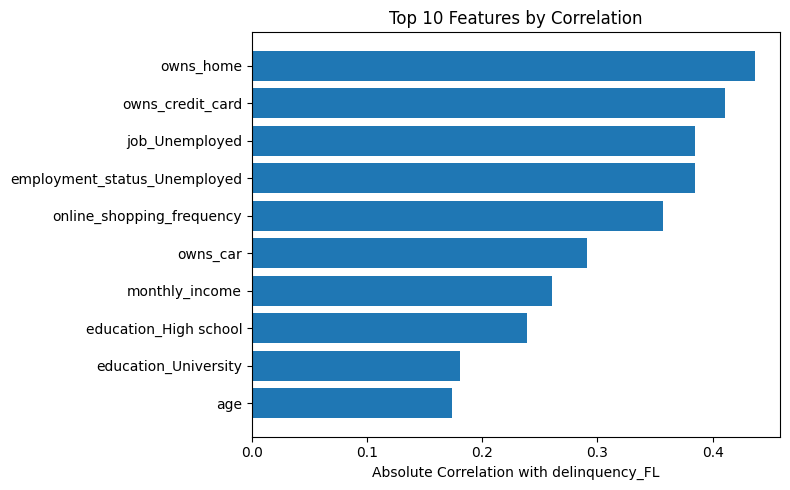

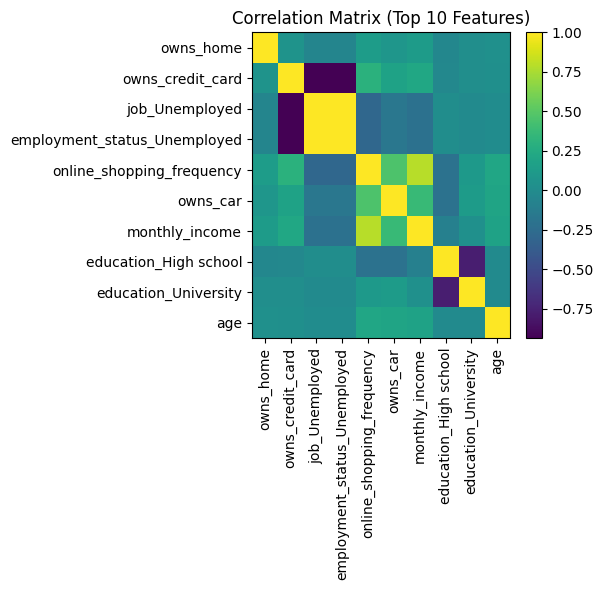

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) One-hot encode and build correlation matrix
features = full_features + [target]
df_corr = pd.get_dummies(df[features], drop_first=True)
corr_matrix = df_corr.corr()

# 2) Identify top 10 features most correlated with target
target_corr = corr_matrix[target].abs().sort_values(ascending=False)
top_features = target_corr.index[1:11]  # skip the target itself

# 3) Bar chart of top correlations
plt.figure(figsize=(8, 5))
plt.barh(range(len(top_features)), target_corr[top_features])
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Absolute Correlation with delinquency_FL")
plt.title("Top 10 Features by Correlation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4) Heatmap of correlations among those top 10 features
sub_corr = corr_matrix.loc[top_features, top_features]
plt.figure(figsize=(6, 6))
plt.imshow(sub_corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.yticks(range(len(top_features)), top_features)
plt.title("Correlation Matrix (Top 10 Features)")
plt.tight_layout()
plt.show()


### Instantiate the Models

In [9]:
import pandas as pd
import numpy as np

from sklearn.impute           import SimpleImputer
from sklearn.preprocessing    import StandardScaler, OneHotEncoder
from sklearn.compose          import ColumnTransformer
from sklearn.pipeline         import Pipeline
from sklearn.linear_model     import LogisticRegression
from sklearn.ensemble         import RandomForestClassifier
from sklearn.tree             import DecisionTreeClassifier

from catboost                 import CatBoostClassifier
from lightgbm                 import LGBMClassifier
from xgboost                  import XGBClassifier

# ─── helpers ─────────────────────────────────────────────────────────────

def split_cols(df, cols):
    cat, num = [], []
    for c in cols:
        if df[c].dtype in ("object","bool") or str(df[c].dtype).startswith("category"):
            cat.append(c)
        else:
            num.append(c)
    return cat, num

def make_pipeline(model, features):
    """Impute+scale numeric, OHE categorical, then model."""
    if isinstance(model, Pipeline):
        return model

    # map feature names → positions
    pos = {f:i for i,f in enumerate(features)}
    cat_cols, num_cols = split_cols(df, features)
    cat_i = [pos[c] for c in cat_cols]
    num_i = [pos[n] for n in num_cols]

    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler())
    ])

    pre = ColumnTransformer([
        ("num", num_pipe,                 num_i),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_i),
    ], sparse_threshold=0)

    return Pipeline([("pre", pre), ("clf", model)])

# ─── your feature lists ────────────────────────────────────────────────────

demographic = [
    "age","education","employment_status","job",
    "monthly_income","home_district","owns_home"
]

alternative = [
    "monthly_rent",            
    "phone_model","phone_purchase_date",
    "owns_car","car_brand","car_purchase_date",
    "owns_credit_card","monthly_subscription_cost",
    "online_shopping_frequency","social_media_active"
]

full_features = demographic + alternative
target        = "delinquency_FL"

# ─── model specifications ──────────────────────────────────────────────────

model_specs = {}

# CatBoost on demo vs full
for tag, feats in (("CatBoost-Demo", demographic), ("CatBoost-Full", full_features)):
    model_specs[tag] = (
        CatBoostClassifier(
            iterations=1000, depth=6, learning_rate=0.3,
            task_type="GPU", devices="0", loss_function="Logloss",
            auto_class_weights="Balanced", od_type="Iter", od_wait=100,
            bootstrap_type="Bernoulli", subsample=0.8, l2_leaf_reg=3,
            verbose=False, random_state=42, allow_writing_files=False
        ), feats
    )

# LightGBM
for tag, feats in (("LGBM-Demo", demographic), ("LGBM-Full", full_features)):
    model_specs[tag] = (
        LGBMClassifier(
            n_estimators=1000, max_depth=6, learning_rate=0.3,
            device="gpu", class_weight="balanced", force_row_wise=True,
            random_state=42, n_jobs=-1, verbosity=-1
        ), feats
    )

# XGBoost
for tag, feats in (("XGB-Demo", demographic), ("XGB-Full", full_features)):
    model_specs[tag] = (
        XGBClassifier(
            n_estimators=1000, max_depth=6, learning_rate=0.3,
            tree_method="hist", predictor="gpu_predictor", gpu_id=0,
            scale_pos_weight=int(75809/24191),
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=0.1,
            use_label_encoder=False, eval_metric="logloss",
            random_state=42, n_jobs=-1
            # we will pass early_stopping_rounds in the training loop
        ), feats
    )

# Logistic Regression
for tag, feats in (("LogReg-Demo", demographic), ("LogReg-Full", full_features)):
    model_specs[tag] = (
        LogisticRegression(
            solver="lbfgs", max_iter=1000,
            class_weight="balanced", tol=1e-4
        ), feats
    )

# Random Forest
for tag, feats in (("RF-Demo", demographic), ("RF-Full", full_features)):
    model_specs[tag] = (
        RandomForestClassifier(
            n_estimators=1000,
            max_depth=6,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        ), feats
    )

# Decision Tree
for tag, feats in (("DT-Demo", demographic), ("DT-Full", full_features)):
    model_specs[tag] = (
        DecisionTreeClassifier(
            max_depth=6,
            class_weight="balanced",
            random_state=42
        ), feats
    )

print("Defined", len(model_specs), "pipelines")


Defined 12 pipelines


### Cross‑validate & display summary table

In [ ]:
import time, copy, joblib
import pandas as pd
import numpy as np

from tqdm.auto                 import tqdm
from sklearn.model_selection   import StratifiedKFold
from sklearn.metrics          import (
    roc_auc_score, f1_score,
    precision_score, recall_score
)
import lightgbm as lgb  # for callbacks


# ─── storage ────────────────────────────────────────────────────────────────

last_pipes  = {}
results     = {}
train_times = {}

y   = df[target]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ─── training loop ─────────────────────────────────────────────────────────

for name, (estimator, feats) in model_specs.items():
    last_pipes[name] = None
    t0 = time.time()
    fold_metrics = {m: [] for m in ("AUC","F1","Precision","Recall","KS")}

    for train_idx, test_idx in tqdm(
        skf.split(df, y), total=5, desc=f"{name} CV"
    ):
        X_tr = df.iloc[train_idx][feats]
        X_te = df.iloc[test_idx][feats]
        y_tr = y.iloc[train_idx]
        y_te = y.iloc[test_idx]

        pipe = make_pipeline(estimator, feats)

        # ─── CatBoost ───────────────────────────────────────────────────────
        if isinstance(estimator, CatBoostClassifier):
            pre = pipe.named_steps["pre"]
            X_tr_e = pre.fit_transform(X_tr)
            X_te_e = pre.transform(X_te)
            clf = pipe.named_steps["clf"]
            clf.fit(
                X_tr_e, y_tr,
                eval_set=[(X_te_e, y_te)],
                early_stopping_rounds=100,
                verbose=False
            )
            prob = clf.predict_proba(X_te_e)[:,1]

        # ─── LightGBM ───────────────────────────────────────────────────────
        elif isinstance(estimator, LGBMClassifier):
            pre = pipe.named_steps["pre"]
            X_tr_e = pre.fit_transform(X_tr)
            X_te_e = pre.transform(X_te)
            clf = pipe.named_steps["clf"]
            clf.fit(
                X_tr_e, y_tr,
                eval_set=[(X_te_e, y_te)],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=0)
                ]
            )
            prob = clf.predict_proba(X_te_e)[:,1]

        # ─── XGBoost ───────────────────────────────────────────────────────
        elif isinstance(estimator, XGBClassifier):
            pre = pipe.named_steps["pre"]
            X_tr_e = pre.fit_transform(X_tr)
            X_te_e = pre.transform(X_te)
            clf = pipe.named_steps["clf"]
            clf.fit(
                X_tr_e, y_tr,
                eval_set=[(X_te_e, y_te)],

                verbose=False
            )
            prob = clf.predict_proba(X_te_e)[:,1]

        # ─── all others ───────────────────────────────────────────────────────
        else:
            pipe.fit(X_tr, y_tr)
            prob = pipe.predict_proba(X_te)[:,1]

        # stash the last‐fold–fitted pipeline
        last_pipes[name] = copy.deepcopy(pipe)

        # collect metrics
        pred = (prob >= 0.5).astype(int)
        fold_metrics["AUC"].append(       roc_auc_score(y_te, prob))
        fold_metrics["F1"].append(        f1_score(      y_te, pred))
        fold_metrics["Precision"].append( precision_score(y_te, pred))
        fold_metrics["Recall"].append(    recall_score(  y_te, pred))

    # end of 5 folds
    results[name]     = {m: np.mean(v) for m,v in fold_metrics.items()}
    train_times[name] = round(time.time() - t0, 2)

# ─── summary & save ────────────────────────────────────────────────────────

metrics_df = pd.DataFrame(results).T.round(4)
metrics_df["Train Time (s)"] = pd.Series(train_times)
print(metrics_df)

for name, pipe in last_pipes.items():
    joblib.dump(pipe, f"{name}_pipeline.joblib")
    print(f"→ Saved {name}_pipeline.joblib")


CatBoost-Demo CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


CatBoost-Full CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


LGBM-Demo CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.237955


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.236569


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.240663


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.239541


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.231801


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


LGBM-Full CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.132419


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.12179


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.125971


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.12664


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.120928


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


XGB-Demo CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:28:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:28:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:28:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predi

XGB-Full CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predi

LogReg-Demo CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


LogReg-Full CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


RF-Demo CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


RF-Full CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


DT-Demo CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


DT-Full CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


                  AUC      F1  Precision  Recall  KS  Train Time (s)
CatBoost-Demo  0.9520  0.8477     0.7905  0.9140 NaN           13.71
CatBoost-Full  0.9648  0.9479     0.9609  0.9353 NaN           20.06
LGBM-Demo      0.9513  0.8460     0.7864  0.9155 NaN            5.07
LGBM-Full      0.9654  0.9494     0.9646  0.9347 NaN            9.56
XGB-Demo       0.9420  0.8283     0.7850  0.8766 NaN           14.22
XGB-Full       0.9645  0.9491     0.9670  0.9318 NaN           16.21
LogReg-Demo    0.9324  0.7817     0.6979  0.8883 NaN            2.01
LogReg-Full    0.9423  0.7931     0.7098  0.8987 NaN            4.90
RF-Demo        0.9417  0.8178     0.7305  0.9289 NaN           15.06
RF-Full        0.9533  0.8453     0.7750  0.9297 NaN           17.98
DT-Demo        0.9492  0.8450     0.7837  0.9168 NaN            1.97
DT-Full        0.9585  0.9124     0.8959  0.9295 NaN            3.75
→ Saved CatBoost-Demo_pipeline.joblib
→ Saved CatBoost-Full_pipeline.joblib
→ Saved LGBM-Demo_pipeline.

### Visualization

c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== Raw Metrics ===
AUCs:
  CatBoost (Demo)           0.954962
  CatBoost (Full)           0.978995
  LightGBM (Demo)           0.956920
  LightGBM (Full)           0.992402
  XGBoost (Demo)            0.982793
  XGBoost (Full)            0.993484
  LogReg (Demo)             0.932617
  LogReg (Full)             0.943057
  RandomForest (Demo)       0.942527
  RandomForest (Full)       0.953999
  DecisionTree (Demo)       0.951199
  DecisionTree (Full)       0.961365

Average Precision (AP):
  CatBoost (Demo)           0.900531
  CatBoost (Full)           0.957714
  LightGBM (Demo)           0.905031
  LightGBM (Full)           0.985168
  XGBoost (Demo)            0.956522
  XGBoost (Full)            0.989477
  LogReg (Demo)             0.843088
  LogReg (Full)             0.878523
  RandomForest (Demo)       0.864348
  RandomForest (Full)       0.908920
  DecisionTree (Demo)       0.871425
  DecisionTree (Full)       0.911360


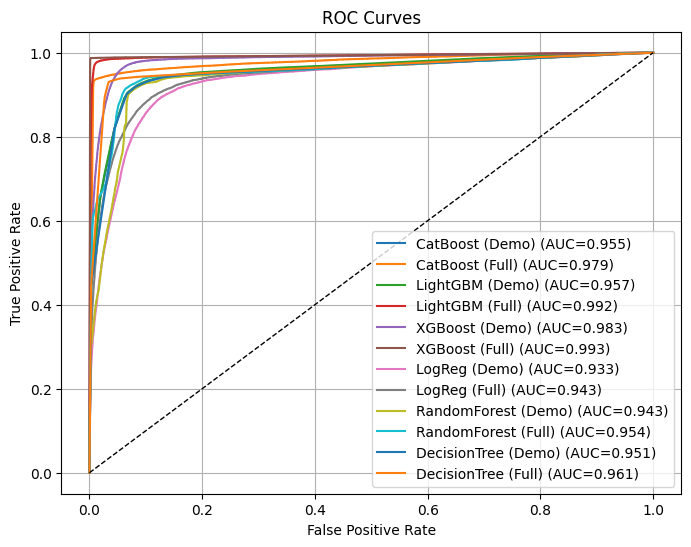

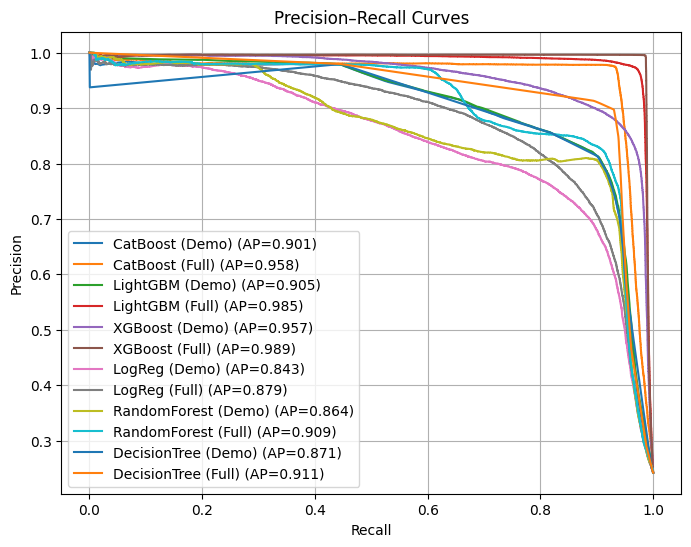

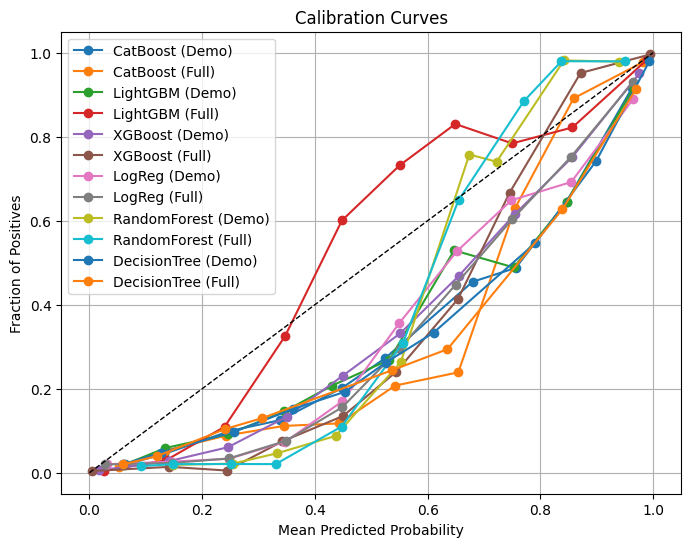

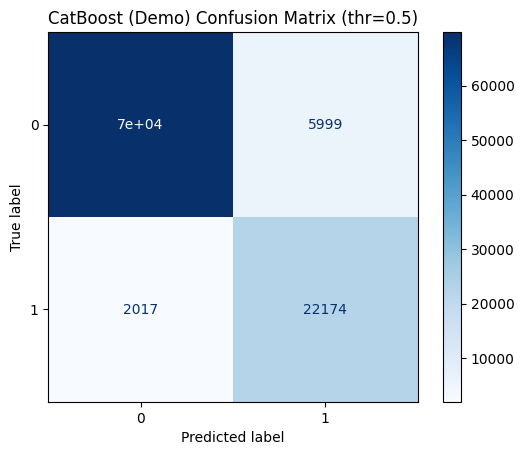

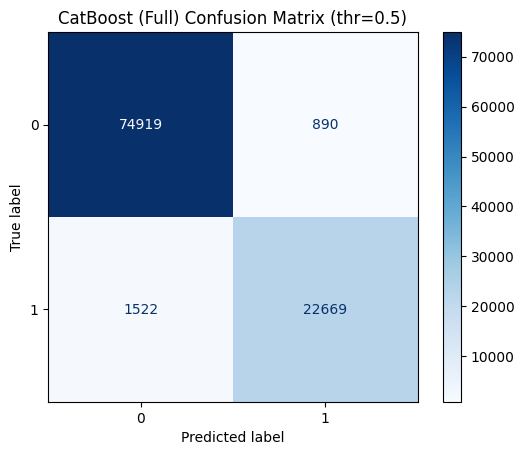

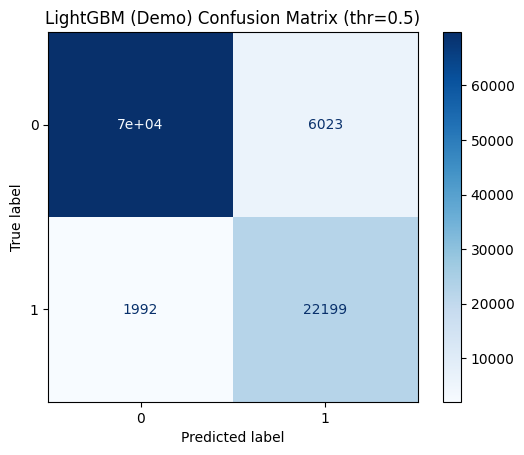

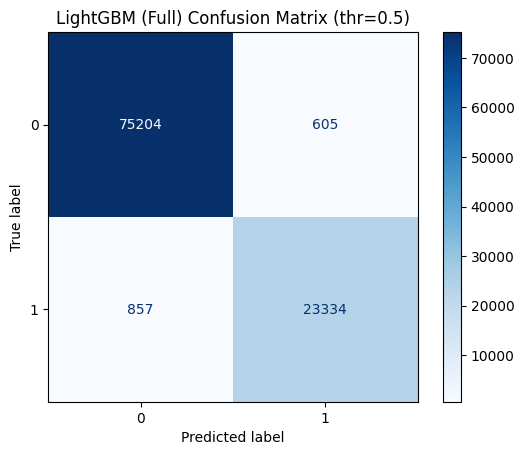

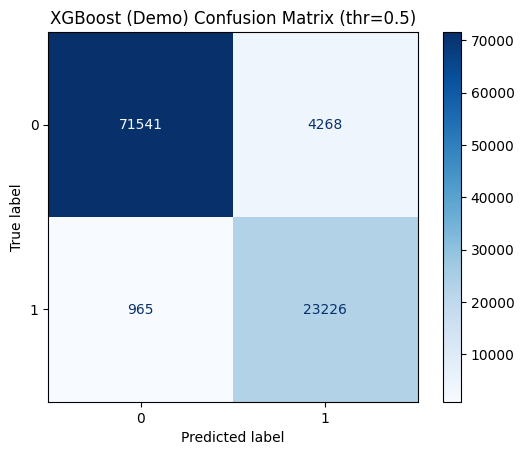

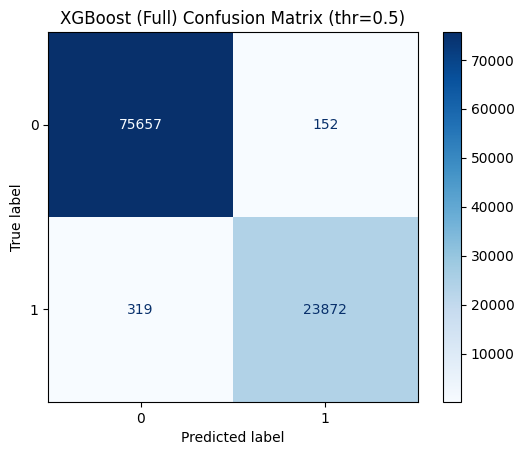

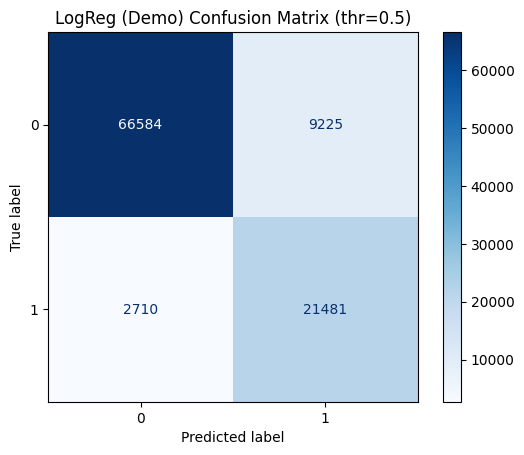

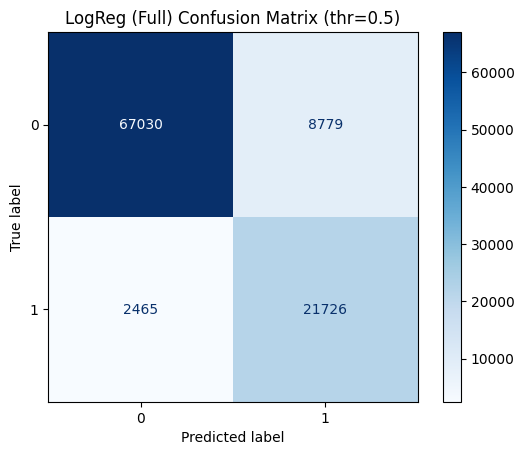

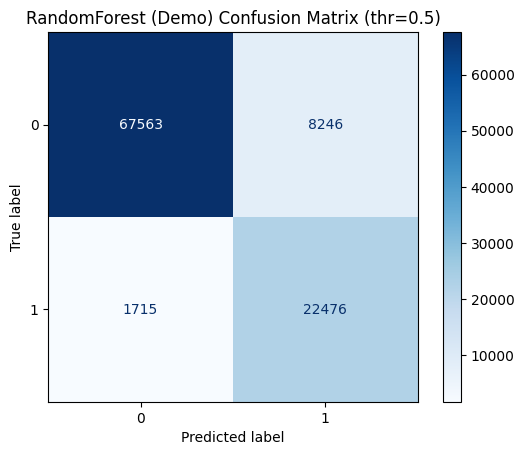

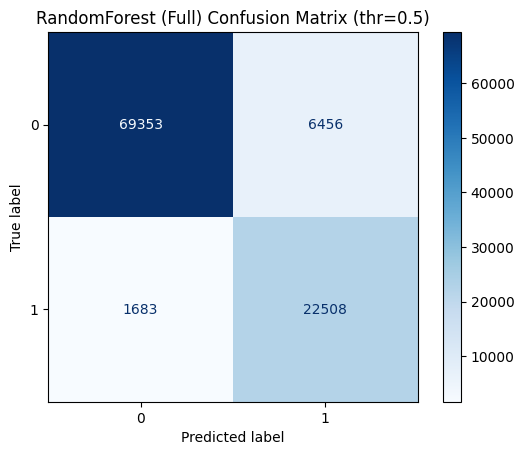

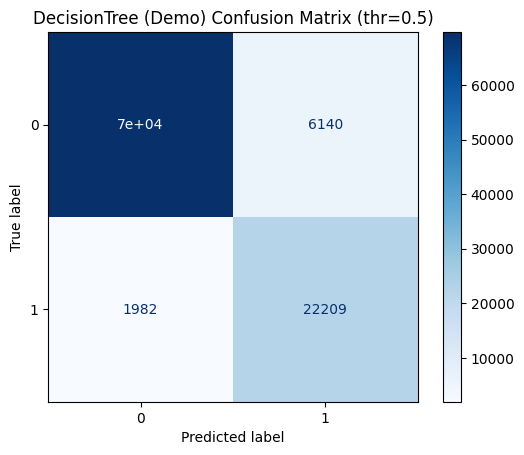

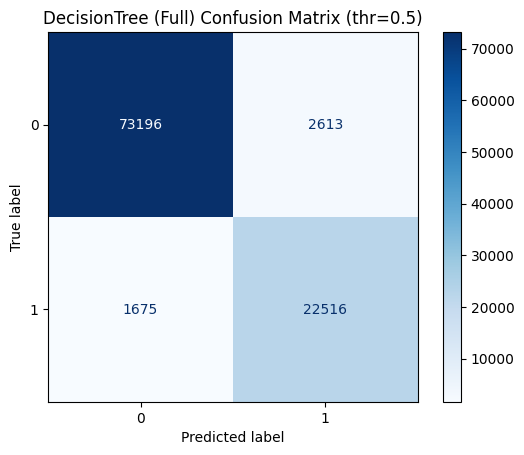

In [12]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

# ─── 1) data & targets ─────────────────────────────────────────────────────
X = df[full_features]
y = df[target]

# ─── 2) load your pipelines ────────────────────────────────────────────────
model_files = {
    "CatBoost-Demo": "CatBoost-Demo_pipeline.joblib",
    "CatBoost-Full": "CatBoost-Full_pipeline.joblib",
    "LGBM-Demo":      "LGBM-Demo_pipeline.joblib",
    "LGBM-Full":      "LGBM-Full_pipeline.joblib",
    "XGB-Demo":       "XGB-Demo_pipeline.joblib",
    "XGB-Full":       "XGB-Full_pipeline.joblib",
    "LogReg-Demo":    "LogReg-Demo_pipeline.joblib",
    "LogReg-Full":    "LogReg-Full_pipeline.joblib",
    "RF-Demo":        "RF-Demo_pipeline.joblib",
    "RF-Full":        "RF-Full_pipeline.joblib",
    "DT-Demo":        "DT-Demo_pipeline.joblib",
    "DT-Full":        "DT-Full_pipeline.joblib",
}

# friendlier legend names
display_names = {
    "CatBoost-Demo": "CatBoost (Demo)",
    "CatBoost-Full": "CatBoost (Full)",
    "LGBM-Demo":      "LightGBM (Demo)",
    "LGBM-Full":      "LightGBM (Full)",
    "XGB-Demo":       "XGBoost (Demo)",
    "XGB-Full":       "XGBoost (Full)",
    "LogReg-Demo":    "LogReg (Demo)",
    "LogReg-Full":    "LogReg (Full)",
    "RF-Demo":        "RandomForest (Demo)",
    "RF-Full":        "RandomForest (Full)",
    "DT-Demo":        "DecisionTree (Demo)",
    "DT-Full":        "DecisionTree (Full)",
}

pipelines = {name: joblib.load(fname) for name, fname in model_files.items()}

# ─── 3) get predicted probabilities ──────────────────────────────────────────
probs = {name: pl.predict_proba(X)[:,1] for name,pl in pipelines.items()}

# ─── 4) raw metrics ─────────────────────────────────────────────────────────
raw_aucs = {}
raw_aps  = {}
for name, p in probs.items():
    fpr, tpr, _ = roc_curve(y, p)
    raw_aucs[name] = auc(fpr, tpr)
    raw_aps[name]  = average_precision_score(y, p)

print("=== Raw Metrics ===\nAUCs:")
for name in model_files:
    print(f"  {display_names[name]:<25} {raw_aucs[name]:.6f}")
print("\nAverage Precision (AP):")
for name in model_files:
    print(f"  {display_names[name]:<25} {raw_aps[name]:.6f}")

# ─── 5) ROC curves ──────────────────────────────────────────────────────────
plt.figure(figsize=(8,6))
for name, p in probs.items():
    fpr, tpr, _ = roc_curve(y, p)
    plt.plot(fpr, tpr, label=f"{display_names[name]} (AUC={raw_aucs[name]:.3f})")
plt.plot([0,1],[0,1],"k--",linewidth=1)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ─── 6) Precision–Recall curves ────────────────────────────────────────────
plt.figure(figsize=(8,6))
for name, p in probs.items():
    prec, rec, _ = precision_recall_curve(y, p)
    plt.plot(rec, prec, label=f"{display_names[name]} (AP={raw_aps[name]:.3f})")
plt.title("Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# ─── 7) Calibration plots ──────────────────────────────────────────────────
plt.figure(figsize=(8,6))
for name, p in probs.items():
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=10)
    plt.plot(mean_pred, frac_pos, "o-", label=display_names[name])
plt.plot([0,1],[0,1],"k--",linewidth=1)
plt.title("Calibration Curves")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# ─── 8) Confusion matrices @ 0.5 threshold ─────────────────────────────────
for name, p in probs.items():
    pred = (p >= 0.5).astype(int)
    cm   = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap="Blues")
    plt.title(f"{display_names[name]} Confusion Matrix (thr=0.5)")
    plt.show()
